# Multiclass classification for e-commerce

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/ecommerceDataset.csv", names=["class", "text"])

## EDA

In [4]:
print(df.loc[100,"text"])

Embroidery Kit for Beginners DIY Kit Total 15 Iteam This embroidery kit is consists of all the basic items that a beginner will require to learn embroidery. This kit can also be a perfect gift for your loved ones.


In [5]:
df.shape

(50425, 2)

Судя по распределению численности описаний карточек товаров, то придется применить технику андерсемплинга / оверсемплинга

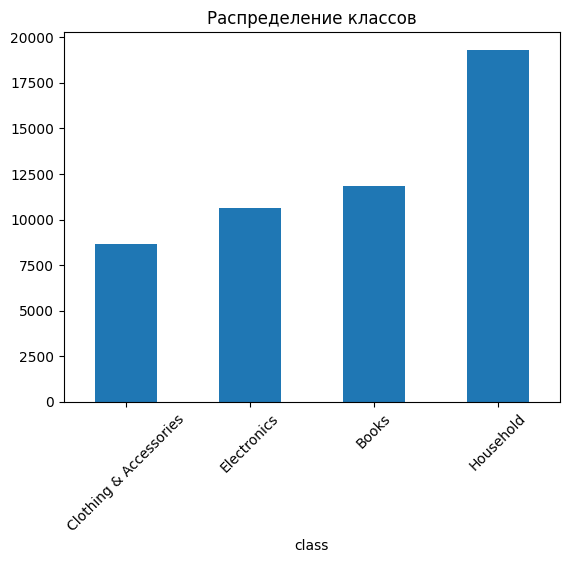

In [6]:
df["class"].value_counts().sort_values().plot(kind='bar') 
plt.title("Распределение классов")
plt.xticks(rotation=45)
plt.show()

In [7]:
df["class"] = df["class"].astype(str)
df["text"] = df["text"].astype(str)

In [8]:
df.loc[:,"len"] = df.text.apply(lambda x: len(x))
df.loc[:,"n"] = df.text.apply(lambda x: len(x.split()))

In [9]:
df["len"].describe()

count    50425.000000
mean       714.098245
std        973.370049
min          3.000000
25%        219.000000
50%        487.000000
75%        954.000000
max      50403.000000
Name: len, dtype: float64

In [10]:
df["n"].describe()

count    50425.000000
mean       114.182053
std        157.806212
min          1.000000
25%         34.000000
50%         78.000000
75%        152.000000
max       8181.000000
Name: n, dtype: float64

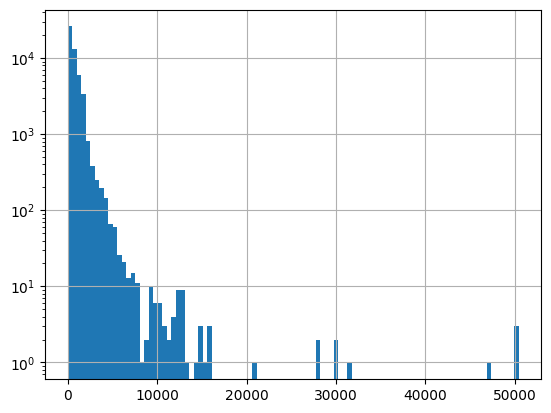

In [11]:
df["len"].hist(bins=100, log=True)
plt.show()

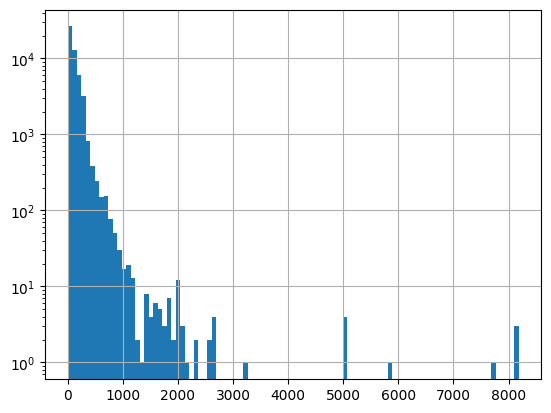

In [12]:
df["n"].hist(bins=100, log=True)
plt.show()

## Data processing

In [13]:
import numpy as np

In [14]:
df = df.drop_duplicates(subset=["class", "text"])
df.reset_index(inplace=True, drop=True)

In [15]:
df.shape

(27803, 4)

Нормальной практикой при очистке датасета является отброс 5-10 % данных 

In [16]:
min_n = np.percentile(df["n"], 2)
max_n = np.percentile(df["n"], 97)
min_n, max_n

(5.0, 350.0)

In [17]:
df = df[(df["n"] > min_n) & (df["n"] < max_n)]

In [18]:
df.shape

(26102, 4)

### Обработка текста

In [19]:
from string import punctuation

from tqdm import tqdm

import nltk 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [20]:
tqdm.pandas()

In [21]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fedorkurusin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fedorkurusin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
STOPWORDS = set(stopwords.words('english'))

In [24]:
lemmatizer = WordNetLemmatizer()
wordnet_map = { 
    "N" : wordnet.NOUN, 
    "V" : wordnet.VERB, 
    "J" : wordnet.ADJ,
    "R" : wordnet.ADV
    }

def lemmatize_words(tokens):
    pos_tagged_text = nltk.pos_tag(tokens)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [25]:
def text_processing(text : str) -> str:
    # lowercase
    text = text.lower()
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))

    # remove stopwords
    tokens = [word for word in str(text).split() if word not in STOPWORDS]

    # lemmatization
    text = lemmatize_words(tokens)

    return text

In [26]:
df["text"] = df["text"].progress_apply(lambda x: text_processing(x))

  0%|          | 0/26102 [00:00<?, ?it/s]

100%|██████████| 26102/26102 [00:43<00:00, 599.94it/s]


In [27]:
df = df[["text", "class"]]

### Train test split

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["class"], test_size=0.33, shuffle=True, random_state=42, stratify=df["class"])

### Undersampling

In [77]:
# rus = RandomUnderSampler(sampling_strategy='majority', replacement=True)
# X_resampled, y_resampled = rus.fit_resample(
#     X_train.values.reshape(-1, 1), 
#     y_train.values.reshape(-1, 1)
#     )

rus = RandomUnderSampler(sampling_strategy='majority', replacement=True)
X_resampled, y_resampled = rus.fit_resample(
    X_train.values.reshape(-1, 1), 
    y_train.values.reshape(-1, 1)
    )

## Logistic Regression

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [70]:
class_encoder = LabelEncoder()

In [71]:
# y_train_encoded = class_encoder.fit_transform(y_train)
y_train_encoded = class_encoder.fit_transform(y_resampled)
y_test_encoded = class_encoder.transform(y_test)  

In [83]:
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(2, 5),
    max_features=100_000,
    max_df=0.95,
    min_df=0.05,
)
# X = vectorizer.fit_transform(X_train)
X = vectorizer.fit_transform(X_resampled.reshape(1,-1)[0])

In [84]:
clf = LogisticRegression(random_state=0).fit(X, y_train_encoded)

/Users/fedorkurusin/Documents/hes/ai-in-buisness/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
X_test_vec = vectorizer.transform(X_test)

In [86]:
y_pred = clf.predict(X_test_vec)

In [87]:
f"{clf.score(X_test_vec, y_test_encoded):.3f}"

'0.920'

### Result analysis

In [89]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [90]:
print(classification_report(y_pred, y_test_encoded, target_names=class_encoder.classes_))

                        precision    recall  f1-score   support

                 Books       0.91      0.92      0.92      1669
Clothing & Accessories       0.97      0.94      0.95      1879
           Electronics       0.91      0.88      0.89      1759
             Household       0.90      0.94      0.92      3307

              accuracy                           0.92      8614
             macro avg       0.92      0.92      0.92      8614
          weighted avg       0.92      0.92      0.92      8614



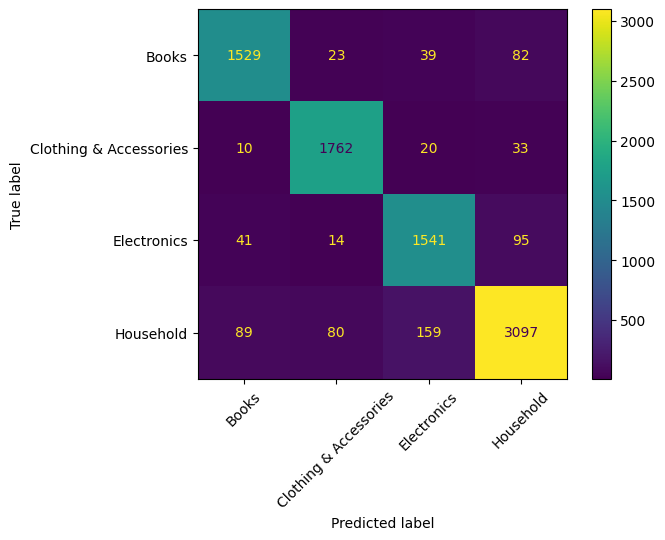

In [91]:
cm = confusion_matrix(
        class_encoder.inverse_transform(y_test_encoded), 
        class_encoder.inverse_transform(y_pred), 
        labels=class_encoder.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_encoder.classes_)
disp.plot()
plt.xticks(rotation=45)
plt.show()

не могу сказать, что вижу какую-то системную ошибку, больше всего электроника предиктится как товары для дома, оно и логично, с точки зрения семантики, эти группы товаров похожи друг с другом. Думаю, можно для начала попрбовать, убрать пересэмплирование, так как мы просто удаляем ценную информацию о группе и информацию о естественном распределении классов. И посмотреть на macro и weighted f1 score

In [92]:
from sklearn.metrics import f1_score

In [93]:
f"{f1_score(y_pred, y_test_encoded, average='macro'):.3f}", f"{f1_score(y_pred, y_test_encoded, average='weighted'):.3f}"

('0.920', '0.920')

In [ ]:
# ('0.920', '0.920')  - resampling on
# ('0.924', '0.925')  - resampling off
